Chuẩn bị dữ liệu đầu vào 

In [19]:
import pickle

TOKENS_FILE = "/kaggle/input/tokens/tokens.pkl"

with open(TOKENS_FILE, "rb") as f:
    tokens = pickle.load(f)

print("Đã load thành công!")
print("Tổng số token:", len(tokens))
print("20 token đầu:", tokens[:20])

Đã load thành công!
Tổng số token: 2653116
20 token đầu: ['hồ', 'chí minh', 'chữ nho', '19', 'tháng', '5', 'năm', '1890', '2', 'tháng', '9', 'năm', '1969', 'tên', 'khai sinh', 'là', 'nguyễn sinh cung', 'chữ nho', 'còn', 'được']


In [20]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


Mã hóa từ và tạo tập huấn luyện 

In [40]:
# Từ điển
word2idx = {w: i+1 for i, w in enumerate(sorted(set(tokens)))}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(word2idx) + 1
print("Kích thước từ vựng:", vocab_size)

# Chuyển token sang id
encoded = [word2idx[w] for w in tokens if w in word2idx]

# Tạo dữ liệu huấn luyện
seq_length = 15   # mô hình nhìn 15 từ để dự đoán từ kế tiếp
sequences = []
for i in range(seq_length, len(encoded)):
    seq = encoded[i-seq_length:i+1]
    sequences.append(seq)

print("Tổng số mẫu:", len(sequences))

Kích thước từ vựng: 102194
Tổng số mẫu: 2653101


Tạo Dataset và DataLoader 

In [41]:
class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = torch.tensor(self.sequences[idx][:-1])
        target = torch.tensor(self.sequences[idx][-1])
        return seq, target

dataset = TextDataset(sequences)
# DataLoader nhanh hơn
loader = DataLoader(
    dataset, batch_size=256, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True
)


Mô hình LSTM

In [42]:
import torch
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512, num_layers=2, dropout=0.4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        # Embedding từ ID sang vector
        x = self.embed(x)
        # Hai tầng LSTM học ngữ cảnh chuỗi
        out, hidden = self.lstm(x, hidden)
        # Dropout để tránh overfitting
        out = self.dropout(out)
        # Lấy output cuối cùng trong chuỗi
        out = self.fc(out[:, -1, :])
        return out, hidden


Huấn luyện mô hình

In [43]:
import torch, math, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.amp import autocast, GradScaler

model = LSTMLanguageModel(vocab_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-3)
scaler = GradScaler('cuda')            
n_epochs = 15                       
model.train()
loss_history = []
ppl_history = []

for epoch in range(n_epochs):
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda'):            
            output, _ = model(X_batch)
            loss = criterion(output, y_batch)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    ppl = math.exp(avg_loss)
    loss_history.append(avg_loss)
    ppl_history.append(ppl)

    print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f} - PPL: {ppl:.2f}")


Epoch 1/15 - Loss: 7.0614 - PPL: 1166.03
Epoch 2/15 - Loss: 6.4066 - PPL: 605.81
Epoch 3/15 - Loss: 6.1747 - PPL: 480.43
Epoch 4/15 - Loss: 6.0460 - PPL: 422.41
Epoch 5/15 - Loss: 5.9639 - PPL: 389.12
Epoch 6/15 - Loss: 5.9061 - PPL: 367.25
Epoch 7/15 - Loss: 5.8622 - PPL: 351.49
Epoch 8/15 - Loss: 5.8267 - PPL: 339.22
Epoch 9/15 - Loss: 5.8009 - PPL: 330.61
Epoch 10/15 - Loss: 5.7776 - PPL: 322.98
Epoch 11/15 - Loss: 5.7622 - PPL: 318.05
Epoch 12/15 - Loss: 5.7451 - PPL: 312.66
Epoch 13/15 - Loss: 5.7342 - PPL: 309.27
Epoch 14/15 - Loss: 5.7225 - PPL: 305.66
Epoch 15/15 - Loss: 5.7151 - PPL: 303.43


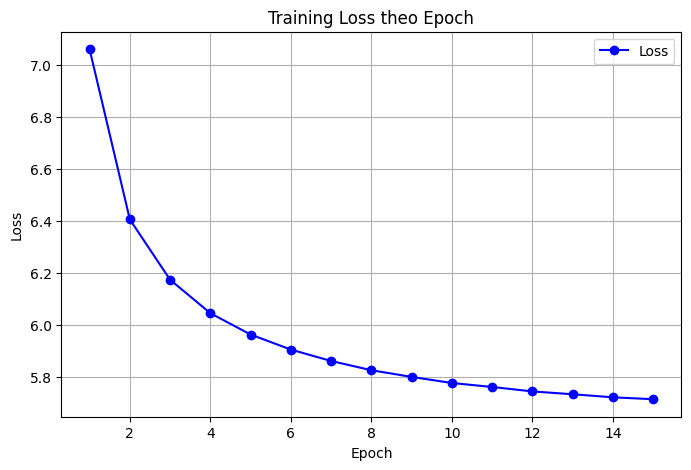

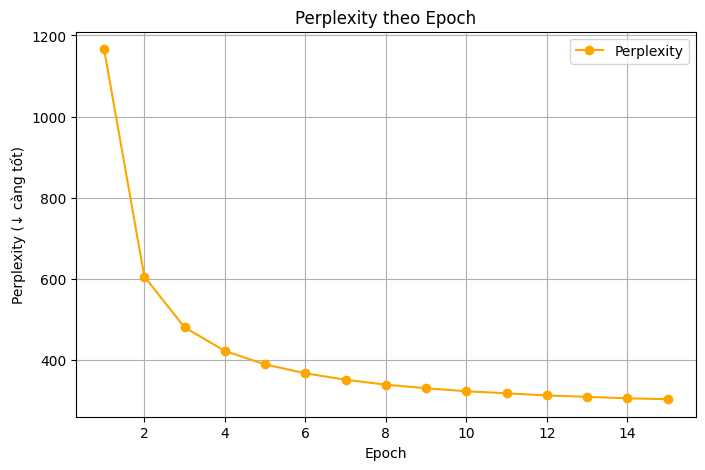

In [46]:
# VẼ BIỂU ĐỒ LOSS & PERPLEXITY
plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), loss_history, marker='o', label="Loss", color='blue')
plt.title("Training Loss theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(range(1, n_epochs+1), ppl_history, marker='o', color='orange', label="Perplexity")
plt.title("Perplexity theo Epoch")
plt.xlabel("Epoch")
plt.ylabel("Perplexity (↓ càng tốt)")
plt.grid(True)
plt.legend()
plt.show()

In [49]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 69.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.6/978.6 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 102.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [65]:
SAVE_PATH = "/kaggle/working/lstm_vi_model.pt"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocab_size': vocab_size,
    'loss_history': loss_history,
    'ppl_history': ppl_history
}, SAVE_PATH)

print(f"Model đã được lưu tại: {SAVE_PATH}")

Model đã được lưu tại: /kaggle/working/lstm_vi_model.pt


In [54]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(
        r"[^a-z0-9àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệ"
        r"ìíỉĩịòóỏõọôồốổỗộơờớởỡợ"
        r"ùúủũụưừứửữựỳýỷỹỵđ\s]",
        " ",
        text
    )
    text = re.sub(r"\s+", " ", text).strip()
    return text

Sinh văn bản

In [55]:
from underthesea import word_tokenize
def generate_text(model, seed_text, next_words=20):
    model.eval()
    words = word_tokenize(preprocess_text(seed_text))
    state_h, state_c = None, None

    for _ in range(next_words):
        x = torch.tensor([[word2idx.get(w, 0) for w in words[-seq_length:]]], dtype=torch.long).to(device)
        with torch.no_grad():
            output, (state_h, state_c) = model(x, (state_h, state_c)) if state_h is not None else model(x)
        prob = torch.softmax(output, dim=-1).squeeze()
        next_idx = torch.argmax(prob).item()
        next_word = idx2word.get(next_idx, "")
        words.append(next_word)
        if next_word in [".", "!", "?"]:
            break
    return " ".join(words)

In [319]:
print(generate_text(model, "Chủ tịch Hồ Chí Minh là người", next_words=25))

chủ tịch hồ chí minh là người có nhiều người sáng lập vĩ đại nhất là phong trào giải phóng dân tộc và phong trào cách mạng việt nam tại việt nam trong giai đoạn này là phong trào cách mạng thanh niên phong trào tuổi trẻ


In [327]:
print(generate_text(model, "Đảng cộng sản là tổ chức", next_words=15))

đảng cộng sản là tổ chức chính trị của đảng lao động việt nam là cơ quan lãnh đạo cao nhất của nhân dân thanh niên là cơ quan


In [411]:
print(generate_text(model, "Đất nước Việt Nam", next_words=15))

đất nước việt nam và việt nam dân chủ cộng hòa là một quốc gia có chủ quyền quốc gia việt nam dân chủ cộng hòa


In [392]:
print(generate_text(model, "Đất nước Việt Nam là một trong những quốc gia", next_words=15))

đất nước việt nam là một trong những quốc gia có mật độ dân số cao nhất thế giới và là một trong những thành phố lớn nhất thế giới


In [330]:
# Các câu khởi đầu để thử
seed_texts = [
    "Chiến dịch Hồ Chí Minh là",
    "Việt Nam hóa chiến tranh là",
    "Văn hóa Việt Nam là sự kết hợp giữa truyền thống và hiện đại",
    "Giáo dục Việt Nam đóng vai trò quan trọng trong việc phát triển",
    "Cuộc Cách mạng tháng Tám năm 1945 đã đánh dấu",
    "Thủ tướng là",
    "Tiếng Việt là"
]

# Sinh văn bản cho từng câu
for text in seed_texts:
    print("=" * 70)
    print("Input:", text)
    print("Generated:", generate_text(model, text, next_words=20))
    print()

Input: Chiến dịch Hồ Chí Minh là
Generated: chiến dịch hồ chí minh là một trong những trận đánh lớn nhất nhất là chiến dịch giải phóng chiến dịch giải phóng miền nam việt nam chiến dịch giải phóng miền nam

Input: Việt Nam hóa chiến tranh là
Generated: việt nam hóa chiến tranh là một trong những cuộc chiến lớn nhất trong chiến tranh việt nam giai đoạn 1975 1975 1975 chiến tranh biên giới bắc việt giai đoạn bắc sơn

Input: Văn hóa Việt Nam là sự kết hợp giữa truyền thống và hiện đại
Generated: văn hóa việt nam là sự kết hợp giữa truyền thống và hiện đại của dân tộc việt nam trong văn hóa việt nam từ thời cổ đại đến thế kỷ xv và những người việt cổ nhất là phật giáo

Input: Giáo dục Việt Nam đóng vai trò quan trọng trong việc phát triển
Generated: giáo dục việt nam đóng vai trò quan trọng trong việc phát triển các vấn đề giáo dục và đào tạo giáo dục đại học và giáo dục đại học quốc gia và đào tạo bậc cử nhân đại học cử nhân quản trị kinh doanh quản trị

Input: Cuộc Cách mạng tháng Tám nă

In [316]:
# Các câu khởi đầu để thử
seed_texts = [
    "Bóng đá",
    "Di sản văn hóa là",
    "Nhà thơ",
    "Hy Lạp cổ đại là quốc gia",
    "Trung Quốc là",
    "Bảo tàng thành phố"
]

# Sinh văn bản cho từng câu
for text in seed_texts:
    print("=" * 70)
    print("Input:", text)
    print("Generated:", generate_text(model, text, next_words=15))
    print()

Input: Bóng đá
Generated: bóng đá việt nam có nhiều cầu thủ bóng đá quốc gia quốc gia việt nam du lịch thể thao việt nam lễ hội võ thuật việt nam lễ hội

Input: Di sản văn hóa là
Generated: di sản văn hóa là một trong những di sản văn hóa phi vật thể nhất thế giới là di sản văn hóa phi vật thể như

Input: Nhà thơ
Generated: nhà thơ và các tác phẩm của ông được xem là một trong những tác phẩm văn học tiêu biểu đầu tiên

Input: Hy Lạp cổ đại là quốc gia
Generated: hy lạp cổ đại là quốc gia của người hy lạp và hy lạp ở hy lạp và vương quốc macedonia vương quốc hy lạp bắt đầu định cư ở

Input: Trung Quốc là
Generated: trung quốc là một trong những nước có mật độ dân số cao nhất thế giới với dân số của hy lạp là

Input: Bảo tàng thành phố
Generated: bảo tàng thành phố hồ chí minh có nhiều công trình kiến trúc kiến trúc kiến trúc cổ nhà hát nhà hát nhà hát di tích lễ hội nghệ thuật



In [389]:
# Các câu khởi đầu để thử
seed_texts = [
    "Truyền thông",
    "Các lễ hội tại",
    "Tư tưởng Hồ Chí Minh",
    "Giải phóng miền Nam",
    "Xã hội chủ nghĩa"
]

# Sinh văn bản cho từng câu
for text in seed_texts:
    print("=" * 70)
    print("Input:", text)
    print("Generated:", generate_text(model, text, next_words=20))
    print()


Input: Truyền thông
Generated: truyền thông của việt nam và các chương trình truyền hình truyền hình truyền hình truyền hình việt nam đã được phát sóng trên kênh vtv1 và kênh vtv3 từ

Input: Các lễ hội tại
Generated: các lễ hội tại việt nam và các lễ hội dân gian truyền thống khác nhau như tín ngưỡng tín ngưỡng thờ thờ lễ hội tín ngưỡng tín ngưỡng dân gian xã hội xã hội xã hội

Input: Tư tưởng Hồ Chí Minh
Generated: tư tưởng hồ chí minh đã có nhiều quan điểm quan trọng trong sự nghiệp hồ chí minh nhà xuất bản chính trị quốc gia sự thật hà nội năm 2006 giáo trình triết học mác thứ

Input: Giải phóng miền Nam
Generated: giải phóng miền nam việt nam và việt nam cộng hòa miền nam việt nam thống nhất thống nhất thống nhất thống nhất toàn tổ quốc dân tộc độc lập độc lập dân tộc việt nam thống nhất là

Input: Xã hội chủ nghĩa
Generated: xã hội chủ nghĩa và các cuộc cách mạng vô sản đã bị áp bức giai cấp vô sản và giai cấp vô sản giai cấp vô sản giai cấp vô sản giai cấp giai cấp vô sản



In [259]:
# Các câu khởi đầu để thử
seed_texts = [
    "Du lịch",
    "Ngày Tết",
    "Ẩm thực Việt Nam nổi tiếng với",
    "Tốc độ tăng trưởng của nền",
    "Nước Đại Việt là"
]

# Sinh văn bản cho từng câu
for text in seed_texts:
    print("=" * 70)
    print("Input:", text)
    print("Generated:", generate_text(model, text, next_words=15))
    print()


Input: Du lịch
Generated: du lịch của việt nam là một trong những nước du lịch có tốc độ tăng trưởng trung bình cao nhất thế giới

Input: Ngày Tết
Generated: ngày tết của người việt ở việt nam thường được dùng để ăn thịt canh đậu món ăn

Input: Ẩm thực Việt Nam nổi tiếng với
Generated: ẩm thực việt nam nổi tiếng với các món ăn khác nhau như món ăn món ăn món ăn món ăn món

Input: Tốc độ tăng trưởng của nền
Generated: tốc độ tăng trưởng của nền kinh tế việt nam là một trong những nước tăng trưởng nhanh nhất thế giới và đứng thứ 2

Input: Nước Đại Việt là
Generated: nước đại việt là một trong những nước có ảnh hưởng lớn nhất trong lịch sử việt nam lịch sử nho giáo nho giáo nho giáo



In [390]:
# TẢI LẠI MÔ HÌNH
checkpoint = torch.load("/kaggle/working/lstm_vi_model.pt", map_location=device)

# Khởi tạo lại model và optimizer với cùng tham số
model = LSTMLanguageModel(checkpoint['vocab_size'])
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-3)

# Nạp trọng số và trạng thái tối ưu hóa
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

loss_history = checkpoint['loss_history']
ppl_history  = checkpoint['ppl_history']

print("Mô hình và optimizer đã được tải lại thành công!")


Mô hình và optimizer đã được tải lại thành công!


In [148]:
import torch, math
from underthesea import word_tokenize

def evaluate_sentence_ppl(model, sentence):
    model.eval()
    toks = word_tokenize(preprocess_text(sentence))
    ids = [word2idx.get(w, 0) for w in toks]

    if len(ids) < 2:
        print("Câu quá ngắn để tính perplexity.")
        return 0, 0

    # Nếu câu ngắn hơn seq_length thì giảm lại
    context_len = min(seq_length, len(ids) - 1)

    total_loss = 0.0
    count = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for i in range(context_len, len(ids)):
            X = torch.tensor([ids[i - context_len:i]], dtype=torch.long).to(device)
            y = torch.tensor([ids[i]], dtype=torch.long).to(device)

            output, _ = model(X)
            loss = criterion(output, y)
            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / max(count, 1)
    ppl = math.exp(avg_loss)
    return ppl, avg_loss

In [156]:
sentence = "Chủ tịch Hồ Chí Minh là người có công lớn trong sự nghiệp giải phóng dân tộc việt nam"
ppl, loss = evaluate_sentence_ppl(model, sentence)

print(f"Sentence: {sentence}")
print(f"Loss: {loss:.4f} | Perplexity: {ppl:.2f}")

Sentence: Chủ tịch Hồ Chí Minh là người có công lớn trong sự nghiệp giải phóng dân tộc việt nam
Loss: 2.2225 | Perplexity: 9.23
